In [1]:
# all imports 
%pylab inline

import os
import sys
import socket

sys.path.append("/root")
sys.path.append("/home/peter")
sys.path.append("/home/peter/Desktop")
sys.path.append("/home/peter/Desktop/projects")
sys.path.append("/home/peter/Desktop/work")
sys.path.append("/home/peter/code/projects")
sys.path.append("/home/peter/code/work")
sys.path.append("/home/peter/code/common")

from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider
from IPython.display import clear_output, display, HTML

import cv2
import os
import pickle as pkl
from sklearn import linear_model
from sklearn.decomposition import PCA
import random as rnd
import numpy as np
import matplotlib.pyplot as plt

import theano.tensor as T
import theano as th

from aidevutil import *

import cymysql as sql
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import datetime
import time
from trading_env import TradingEnv
from numba import jit

Populating the interactive namespace from numpy and matplotlib


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_6ci21qhj.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1050 with Max-Q Design (0000:02:00.0)
Using TensorFlow backend.


vizdoom could not be imported
Pixiedust database opened successfully


In [2]:
np.random.seed()
rnd.seed()

In [3]:
from sklearn.preprocessing import scale, robust_scale, normalize

In [4]:
dataname = 'eurusd_1h'

input_source = np.load("data/data_%s.npy" % dataname)
to_predict = np.load("data/data_%s_targets.npy" % dataname)

to_predict = to_predict[3,:].reshape(-1)

In [5]:
input_source.shape

(320, 51348)

In [6]:
input_source = input_source.T

In [7]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
test_to_predict = to_predict[cp:]
input_source = input_source[0:cp, :]
to_predict = to_predict[0:cp]

In [8]:
test_input_source = test_input_source.T
input_source = input_source.T

In [9]:
input_source.shape, test_input_source.shape

((320, 41078), (320, 10270))

In [10]:
to_predict[0:50]

array([1.3244 , 1.3238 , 1.3243 , 1.32365, 1.32435, 1.3241 , 1.3232 ,
       1.3225 , 1.3218 , 1.322  , 1.3217 , 1.3223 , 1.3214 , 1.322  ,
       1.3211 , 1.32   , 1.3187 , 1.3191 , 1.319  , 1.32075, 1.3215 ,
       1.321  , 1.3215 , 1.323  , 1.3228 , 1.3227 , 1.3232 , 1.3234 ,
       1.323  , 1.3226 , 1.3229 , 1.3236 , 1.3231 , 1.3234 , 1.3223 ,
       1.3223 , 1.3221 , 1.3214 , 1.32285, 1.3234 , 1.3217 , 1.3223 ,
       1.3221 , 1.3226 , 1.322  , 1.3213 , 1.31645, 1.3173 , 1.3175 ,
       1.3181 ])

In [11]:
winlen = 1

In [12]:
sliding_window_jump = 1
predict_time_ahead = 1
binary = 1

In [13]:
def get_partitioned_counts(cl, rr, rt):
    " data, steps_forward, partition_num"
    cl = cl[rr:] - cl[0:-rr]
    cl = hstack([[0]*rr, cl])
    pdown = len(cl[cl < -rt])
    pup = len(cl[cl > rt])
    pmid = len(cl[(cl <= rt) & (cl >= -rt)])
    return pup, pmid, pdown

In [14]:
def partition_data_num(cl, predict_ahead):
    a=[]
    b=[]
    c=[]
    ts = np.linspace(0.001, 100.0, 100000, )
    for x in tqdm(ts):
        au, am, ad = get_partitioned_counts(cl, predict_ahead, x)
        a.append(au)
        b.append(am)
        c.append(ad)
    a, b, c = array(a), array(b), array(c)
    return ts[np.argmin(np.abs(a-b) + np.abs(a-c) + np.abs(b-c))]

In [15]:
# create training set
if not binary:
    sep = partition_data_num(to_predict, predict_time_ahead)
    sep

In [16]:
#@jit
def prepare_data(input_source, to_predict, binary=1, cpp=0.75):

    x = []
    y = []

    ups = []
    downs = []
    mids = []

    for i in range(0, input_source.shape[1]-(winlen+100), sliding_window_jump):
        # form the input
        txs = input_source[:, i:i+winlen]#.astype(np.float64)
        #xs = scale(xs, axis=1)
        xs = txs.ravel()

        # for the output
        now = to_predict[i+winlen-1]# close
        future = to_predict[i+winlen+(predict_time_ahead-1)] # next close

        ys = future-now
        magn = abs(ys)

        if not binary:
            if magn < sep:
                mids.append( (xs, (np.array([1]))) )
            else:
                if ys < 0:
                    downs.append( (xs, (np.array([2]))) )
                else:
                    ups.append( (xs, (np.array([0]))) )
        else:
            if ys <= 0:
                downs.append( (xs, (np.array([1]))) )
            else:
                ups.append( (xs, (np.array([0]))) )

        #if (i%1000)==0:
        #    clear_output(wait=True)
        #    print('({}/{})'.format(i, input_source.shape[1]-winlen))

    #print('Ups: {0} Mids: {1} Downs: {2}'.format(len(ups), len(mids), len(downs)))
    #print('Separator: %3.5f' % sep)
    #print()

    if not binary:
        samplesize = min(len(ups), len(downs), len(mids))
        s1 = rnd.sample(ups, samplesize)
        s2 = rnd.sample(downs, samplesize)
        s3 = rnd.sample(mids, samplesize)
        a = s1 + s2 + s3
    else:
        samplesize = min(len(ups), len(downs))
        s1 = rnd.sample(ups, samplesize)
        s2 = rnd.sample(downs, samplesize)
        a = s1 + s2 
    rnd.shuffle(a)
    x = [x[0] for x in a]
    y = [x[1] for x in a]

    x = np.vstack(x)
    y = np.vstack(y)
    
    x.shape = (x.shape[0], -1)
    cutpoint = int(cpp * x.shape[0])
    x_train = x[0:cutpoint]
    x_test = x[cutpoint:]
    y_train = y[0:cutpoint]
    y_test = y[cutpoint:]
    
    return x_train, x_test, y_train.reshape(-1), y_test.reshape(-1)

In [17]:
#x_train, x_test, y_train, y_test = prepare_data(input_source, to_predict)

In [18]:
#matshow(x[400:500].T); colorbar();

In [19]:
from sklearn.ensemble import AdaBoostClassifier

In [20]:
# Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [21]:
import sklearn as sk
import time

In [22]:
# Use skopt to find best parameters for the classifier
#x_train, x_test, y_train, y_test = prepare_data(input_source, to_predict)

In [23]:
from skopt.benchmarks import branin as branin
from skopt.benchmarks import hart6 as hart6_
from functools import partial
from skopt.plots import plot_evaluations, plot_convergence
from skopt.plots import plot_objective
from skopt import gp_minimize, forest_minimize, dummy_minimize
from skopt import callbacks
#from skopt.callbacks import CheckpointSaver
from skopt import load

In [24]:
param_spaces = {}
param_spaces['xgb'] = {'max_depth': {'space': [1, 2, 3],
                                               'mut_prob': 0.15,
                                               'default': 3},
                                 'learning_rate': {'space': [0.01, 0.05, 0.1, 0.5],
                                                   'mut_prob': 0.15,
                                                   'default': 0.05},
                                 'n_estimators': {'space': [10, 50, 100, 150, 200],
                                                  'mut_prob': 0.15,
                                                  'default': 50},
                                 'min_child_weight': {'space': [1, 2, 3],
                                                      'mut_prob': 0.15,
                                                      'default': 5},
                                 'subsample': {'space': [0.0, 0.8, 1.0],
                                               'mut_prob': 0.15,
                                               'default': 0.5},
                                 'colsample_bytree': {'space': [0.0, 0.8, 1.0],
                                                      'mut_prob': 0.15,
                                                      'default': 0.5},
                                   'colsample_bylevel': {'space': [0.0, 0.8, 1.0],
                                                                  'mut_prob': 0.15,
                                                                  'default': 0.5},
                                   'colsample_bynode': {'space': [0.0, 0.8, 1.0],
                                                                  'mut_prob': 0.15,
                                                                  'default': 0.5},
                                 }

param_spaces['lgr'] = {'solver': {'space': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                                 'mut_prob': 0.15,
                                                 'default': 'liblinear'},
                                      'C': {'space': [0.0, 0.75, 0.95, 1.0],
                                            'mut_prob': 0.15,
                                            'default': 1.0},
                                      'fit_intercept': {'space': [True, False],
                                                        'mut_prob': 0.15,
                                                        'default': True},
                                      }

In [25]:
# 

def optimize_classifier(classifier, cl, verbose=True):
    order = sorted(list(param_spaces[classifier].keys()))

    def testclf(args):
        ps = {}
        for a,o in zip(args,order):
            sp = param_spaces[classifier][o]['space']
            if isinstance(sp[0], int) and isinstance(sp[1], int):
                ps[o] = a
            elif isinstance(sp[0], float) and isinstance(sp[1], float):
                ps[o] = a
            else:
                ps[o] = param_spaces[classifier][o]['space'][a]
                
        #clf = cl(**ps, n_jobs=8)
        #clf.fit(x_train, y_train)
        #sc = clf.score(x_test,y_test)
        print('Trying:', str(ps))
        num_clfs = 5
        clfs = [cl(**ps, n_jobs=8) for x in range(num_clfs)]
        scores_tr, scores_ts = [], []
        for clf in tqdm(clfs):
            x_train, x_test, y_train, y_test = prepare_data(input_source, to_predict)
            clf.fit(x_train, y_train)
            scores_tr.append(clf.score(x_train, y_train))
            scores_ts.append(clf.score(x_test, y_test))
        sc = mean(scores_ts)
        return -sc
    
    bl = []
    for o in order:
        sp = param_spaces[classifier][o]['space']
        if isinstance(sp[0], int) and isinstance(sp[1], int):
            bl.append((sp[0], sp[-1]))
        elif isinstance(sp[0], float) and isinstance(sp[1], float):
            bl.append((sp[0], sp[-1]))
        else:
            bl.append( (0, len(sp)-1) )

    res=None
    try:
        res = gp_minimize(testclf, bl, 
                          n_calls=150,
                          n_random_starts=10, 
                          #callback=[checkpoint_saver],
                          #noise=variance_data[classifier],
                          verbose=verbose)
    except KeyboardInterrupt:
        pass#res = load(fname)
    
    except Exception as ex:
        print(ex)
        
    a = list(zip(order,res.x))
    na = []
    for o, am in a:
        sp = param_spaces[classifier][o]['space']
        if isinstance(sp[0], int) and isinstance(sp[1], int):
            na.append( [o, am] )
        elif isinstance(sp[0], float) and isinstance(sp[1], float):
            na.append( [o, am] )
        else:
            na.append( [o, param_spaces[classifier][o]['space'][am]] )
        
    return dict(na)

In [26]:
d = {}#optimize_classifier('xgb', XGBClassifier, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.2647009326468088, 'colsample_bynode': 0.21135978095991542, 'colsample_bytree': 0.03298947136750364, 'learning_rate': 0.25062540529313876, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 12, 'subsample': 0.5336792475211578}



Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.2470
Function value obtained: -0.5159
Current minimum: -0.5159
Iteration No: 2 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.7876414560548871, 'colsample_bynode': 0.9021758281039556, 'colsample_bytree': 0.9889110768385215, 'learning_rate': 0.20073779636401068, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 92, 'subsample': 0.499573315151446}



Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.6029
Function value obtained: -0.5322
Current minimum: -0.5322
Iteration No: 3 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.8492562773102149, 'colsample_bynode': 0.08151047150748615, 'colsample_bytree': 0.9671613355874972, 'learning_rate': 0.10565996010194054, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 183, 'subsample': 0.4375066157417552}



Iteration No: 3 ended. Evaluation done at random point.
Time taken: 19.9751
Function value obtained: -0.5295
Current minimum: -0.5322
Iteration No: 4 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.31365159906866774, 'colsample_bynode': 0.4969905641965646, 'colsample_bytree': 0.8630682874698672, 'learning_rate': 0.3455237387279191, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 176, 'subsample': 0.5789087762953015}



Iteration No: 4 ended. Evaluation done at random point.
Time taken: 31.8804
Function value obtained: -0.5166
Current minimum: -0.5322
Iteration No: 5 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.13364129620136003, 'colsample_bynode': 0.2565697722268417, 'colsample_bytree': 0.9000148413364671, 'learning_rate': 0.04131241312920707, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 126, 'subsample': 0.7306202419259545}



Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.2140
Function value obtained: -0.5288
Current minimum: -0.5322
Iteration No: 6 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.9918112276803752, 'colsample_bynode': 0.5889086918077258, 'colsample_bytree': 0.9529967885691234, 'learning_rate': 0.43459335120476794, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 51, 'subsample': 0.6252821779281932}



Iteration No: 6 ended. Evaluation done at random point.
Time taken: 20.7429
Function value obtained: -0.5207
Current minimum: -0.5322
Iteration No: 7 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.8290032182538281, 'colsample_bynode': 0.8822807146414099, 'colsample_bytree': 0.28168923013775, 'learning_rate': 0.3188203564671216, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 190, 'subsample': 0.06736025349195564}



Iteration No: 7 ended. Evaluation done at random point.
Time taken: 18.1478
Function value obtained: -0.5040
Current minimum: -0.5322
Iteration No: 8 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.17958889311528672, 'colsample_bynode': 0.8499867194052447, 'colsample_bytree': 0.9323519164845181, 'learning_rate': 0.4550449675693243, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 172, 'subsample': 0.0325486143643361}



Iteration No: 8 ended. Evaluation done at random point.
Time taken: 17.2881
Function value obtained: -0.5076
Current minimum: -0.5322
Iteration No: 9 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.5851738046598263, 'colsample_bynode': 0.022989088355421353, 'colsample_bytree': 0.9331978413341459, 'learning_rate': 0.06002719445435995, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 122, 'subsample': 0.09345281707449339}



Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.3298
Function value obtained: -0.5213
Current minimum: -0.5322
Iteration No: 10 started. Evaluating function at random point.
Trying: {'colsample_bylevel': 0.08271687351345682, 'colsample_bynode': 0.5011186773582548, 'colsample_bytree': 0.9355131396985131, 'learning_rate': 0.418463448399504, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 115, 'subsample': 0.377421155364572}



Iteration No: 10 ended. Evaluation done at random point.
Time taken: 13.8253
Function value obtained: -0.5134
Current minimum: -0.5322
Iteration No: 11 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 1.0}



Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 5.1992
Function value obtained: -0.5158
Current minimum: -0.5322
Iteration No: 12 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.5405099874072254}



Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 5.0746
Function value obtained: -0.5154
Current minimum: -0.5322
Iteration No: 13 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.11456977224799073, 'colsample_bynode': 0.9281882661473573, 'colsample_bytree': 0.0545354905923099, 'learning_rate': 0.018678743823315944, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 25, 'subsample': 0.9902101095154544}



Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 5.8843
Function value obtained: -0.5168
Current minimum: -0.5322
Iteration No: 14 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.09929302650800267, 'colsample_bynode': 0.9057564913120799, 'colsample_bytree': 0.012446606788728557, 'learning_rate': 0.012568270771734957, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 57, 'subsample': 0.3755919746093148}



Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 7.2753
Function value obtained: -0.5194
Current minimum: -0.5322
Iteration No: 15 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9260928917606341, 'colsample_bynode': 0.025247527960062584, 'colsample_bytree': 0.0028035760969720163, 'learning_rate': 0.02011964576519662, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 168, 'subsample': 0.297745494311399}



Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 13.9066
Function value obtained: -0.5166
Current minimum: -0.5322
Iteration No: 16 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9031124110691341, 'colsample_bynode': 0.6832807743377369, 'colsample_bytree': 0.03043503802828674, 'learning_rate': 0.493500003120266, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 18, 'subsample': 0.14636353171920494}



Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 6.4004
Function value obtained: -0.5173
Current minimum: -0.5322
Iteration No: 17 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.6763960882175842, 'colsample_bynode': 0.019945726422609947, 'colsample_bytree': 0.9732669789875927, 'learning_rate': 0.4956696006842451, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 42, 'subsample': 0.8453256665255364}



Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 6.8608
Function value obtained: -0.5280
Current minimum: -0.5322
Iteration No: 18 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.04853455123372609, 'colsample_bynode': 0.8666302775719452, 'colsample_bytree': 0.11328431763512128, 'learning_rate': 0.4744907181235875, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.98774239252563}



Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 16.4729
Function value obtained: -0.5238
Current minimum: -0.5322
Iteration No: 19 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 15.1381
Function value obtained: -0.5209
Current minimum: -0.5322
Iteration No: 20 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 1.0}



Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.9817
Function value obtained: -0.5337
Current minimum: -0.5337
Iteration No: 21 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.0, 'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 16.6967
Function value obtained: -0.5167
Current minimum: -0.5337
Iteration No: 22 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.972280861655391, 'colsample_bynode': 0.17635918819022114, 'colsample_bytree': 0.020956320108619256, 'learning_rate': 0.3957124309140667, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 15, 'subsample': 0.9865681094764885}



Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 6.0031
Function value obtained: -0.5147
Current minimum: -0.5337
Iteration No: 23 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.5622090971914586, 'colsample_bytree': 1.0, 'learning_rate': 0.17216961200098024, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 42.6339
Function value obtained: -0.5304
Current minimum: -0.5337
Iteration No: 24 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.0, 'colsample_bynode': 0.0, 'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.5353718299302315}



Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 16.9135
Function value obtained: -0.5240
Current minimum: -0.5337
Iteration No: 25 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 1.0}



Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.7096
Function value obtained: -0.5228
Current minimum: -0.5337
Iteration No: 26 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8117785219343854}



Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 57.7552
Function value obtained: -0.5291
Current minimum: -0.5337
Iteration No: 27 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8904139793790153, 'colsample_bynode': 0.012103357463919665, 'colsample_bytree': 0.9572613854873364, 'learning_rate': 0.3887333896605728, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 94, 'subsample': 0.01954477771824448}



Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 12.1019
Function value obtained: -0.5069
Current minimum: -0.5337
Iteration No: 28 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.0, 'colsample_bynode': 0.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 17.2910
Function value obtained: -0.5166
Current minimum: -0.5337
Iteration No: 29 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8674127445151273, 'colsample_bynode': 0.984386597874676, 'colsample_bytree': 0.1437886850386532, 'learning_rate': 0.16232390789294462, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 190, 'subsample': 0.7035954804154138}



Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 20.7882
Function value obtained: -0.5304
Current minimum: -0.5337
Iteration No: 30 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.08540369927999016, 'colsample_bynode': 0.9073010677630576, 'colsample_bytree': 0.07916058167985131, 'learning_rate': 0.46720805270136473, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6878671970568941}



Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 16.2542
Function value obtained: -0.5192
Current minimum: -0.5337
Iteration No: 31 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.6638075624060937, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8310052785406441}



Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 48.8113
Function value obtained: -0.5363
Current minimum: -0.5363
Iteration No: 32 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9828345547762778, 'colsample_bynode': 0.04423532033193001, 'colsample_bytree': 0.33096714878278727, 'learning_rate': 0.4664232609129721, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 173, 'subsample': 0.008032490860814036}



Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 14.3914
Function value obtained: -0.5023
Current minimum: -0.5363
Iteration No: 33 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.5184991382224134, 'colsample_bynode': 0.9255859194079455, 'colsample_bytree': 0.998744193472513, 'learning_rate': 0.01460367806156317, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 197, 'subsample': 0.30310578293193763}



Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 57.6943
Function value obtained: -0.5341
Current minimum: -0.5363
Iteration No: 34 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9227906662697597, 'colsample_bynode': 0.9456291524523607, 'colsample_bytree': 0.9925880146225179, 'learning_rate': 0.07495795721149615, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 166, 'subsample': 0.6447209095163743}



Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 104.6212
Function value obtained: -0.5294
Current minimum: -0.5363
Iteration No: 35 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 16.1500
Function value obtained: -0.5168
Current minimum: -0.5363
Iteration No: 36 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.03288133578094344, 'colsample_bynode': 0.2255249810563092, 'colsample_bytree': 0.7291012258433076, 'learning_rate': 0.010254798527202458, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 89, 'subsample': 0.03165362098952985}



Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.1984
Function value obtained: -0.5164
Current minimum: -0.5363
Iteration No: 37 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9723189487361227, 'colsample_bynode': 0.9795444541777019, 'colsample_bytree': 0.9311721096932848, 'learning_rate': 0.07176966776999724, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 146, 'subsample': 0.46885868480715265}



Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 37.5717
Function value obtained: -0.5325
Current minimum: -0.5363
Iteration No: 38 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.09870756351194934, 'colsample_bynode': 0.9604091798812666, 'colsample_bytree': 0.7632833200429322, 'learning_rate': 0.018345368708350275, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 36, 'subsample': 0.027644949382542923}



Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.7568
Function value obtained: -0.5197
Current minimum: -0.5363
Iteration No: 39 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.607986375921096, 'colsample_bynode': 0.5962032652002706, 'colsample_bytree': 1.0, 'learning_rate': 0.0958827196219338, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 35.5771
Function value obtained: -0.5305
Current minimum: -0.5363
Iteration No: 40 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9912781137598241, 'colsample_bynode': 0.9074973926685794, 'colsample_bytree': 0.729289556142275, 'learning_rate': 0.03281565701176084, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 52, 'subsample': 0.05721984066919829}



Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 12.9165
Function value obtained: -0.5283
Current minimum: -0.5363
Iteration No: 41 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.6739215516326902, 'colsample_bytree': 1.0, 'learning_rate': 0.06522874698285543, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.6300540526559211}



Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 12.5347
Function value obtained: -0.5308
Current minimum: -0.5363
Iteration No: 42 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.13939590315872036, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 61.1184
Function value obtained: -0.5319
Current minimum: -0.5363
Iteration No: 43 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.794172276117659, 'colsample_bynode': 0.6946318689795904, 'colsample_bytree': 1.0, 'learning_rate': 0.07986804301236045, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6048637485958761}



Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 34.4954
Function value obtained: -0.5287
Current minimum: -0.5363
Iteration No: 44 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9786250929671346, 'colsample_bynode': 0.9916916613538034, 'colsample_bytree': 0.6324386891382132, 'learning_rate': 0.4907194644913962, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 126, 'subsample': 0.9164300643286126}



Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 36.4480
Function value obtained: -0.5251
Current minimum: -0.5363
Iteration No: 45 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.0, 'colsample_bynode': 0.0, 'colsample_bytree': 1.0, 'learning_rate': 0.2805532441763777, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 68, 'subsample': 1.0}



Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 8.1915
Function value obtained: -0.5188
Current minimum: -0.5363
Iteration No: 46 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.024744772948411826, 'colsample_bynode': 0.14548353417787843, 'colsample_bytree': 0.1267558043402485, 'learning_rate': 0.49625283035987017, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 139, 'subsample': 0.998967515696876}



Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 11.4743
Function value obtained: -0.5204
Current minimum: -0.5363
Iteration No: 47 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9195435419403287, 'colsample_bynode': 0.9361882889840605, 'colsample_bytree': 0.9303122806380174, 'learning_rate': 0.47728038012631924, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 142, 'subsample': 0.9364632721663155}



Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 102.7538
Function value obtained: -0.5181
Current minimum: -0.5363
Iteration No: 48 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.12215167405553785, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6570413695449979}



Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 53.7238
Function value obtained: -0.5291
Current minimum: -0.5363
Iteration No: 49 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8548211094516187, 'colsample_bynode': 0.9997380150085737, 'colsample_bytree': 0.7530112506293182, 'learning_rate': 0.1307753177403781, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 24, 'subsample': 0.06284323716270791}



Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 9.4983
Function value obtained: -0.5214
Current minimum: -0.5363
Iteration No: 50 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8617649096995798, 'colsample_bynode': 0.9820655278293865, 'colsample_bytree': 0.714403508880981, 'learning_rate': 0.1538226277633787, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 76, 'subsample': 0.9559190108052105}



Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 42.0730
Function value obtained: -0.5263
Current minimum: -0.5363
Iteration No: 51 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.4582411257177167, 'colsample_bynode': 0.9894962538589198, 'colsample_bytree': 0.9959183844435199, 'learning_rate': 0.3422936945794319, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 43, 'subsample': 0.9935780156311663}



Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 11.0827
Function value obtained: -0.5303
Current minimum: -0.5363
Iteration No: 52 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.13361250683132822, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.699609521605395}



Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 7.2451
Function value obtained: -0.5296
Current minimum: -0.5363
Iteration No: 53 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9623571374650614, 'colsample_bynode': 0.9836023611051138, 'colsample_bytree': 0.0004486526703129102, 'learning_rate': 0.013185615180899564, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 156, 'subsample': 0.15895160561912627}



Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 15.0634
Function value obtained: -0.5199
Current minimum: -0.5363
Iteration No: 54 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.12181742113157835, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6728004084135026}



Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 58.4713
Function value obtained: -0.5306
Current minimum: -0.5363
Iteration No: 55 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8131321670860258, 'colsample_bynode': 0.8177275204754275, 'colsample_bytree': 0.9166579962335011, 'learning_rate': 0.3119396761010829, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 199, 'subsample': 0.9785339522114822}



Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 41.0817
Function value obtained: -0.5292
Current minimum: -0.5363
Iteration No: 56 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.6843570249661077, 'colsample_bytree': 1.0, 'learning_rate': 0.12692647823419986, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6982379849654368}



Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 41.6161
Function value obtained: -0.5296
Current minimum: -0.5363
Iteration No: 57 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9382770080362824, 'colsample_bynode': 0.9524633923472997, 'colsample_bytree': 0.7458573572080508, 'learning_rate': 0.19246493339672285, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 21, 'subsample': 0.9928504374651467}



Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 15.8259
Function value obtained: -0.5277
Current minimum: -0.5363
Iteration No: 58 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.4665166770417649, 'colsample_bynode': 0.8752921444498493, 'colsample_bytree': 0.9291018508525436, 'learning_rate': 0.014059271116181878, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 110, 'subsample': 0.8430179385307198}



Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 39.0495
Function value obtained: -0.5317
Current minimum: -0.5363
Iteration No: 59 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8256621036746744, 'colsample_bynode': 0.9871439769290585, 'colsample_bytree': 0.9460980256251655, 'learning_rate': 0.02058331031914829, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 197, 'subsample': 0.6650766614872342}



Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 107.2034
Function value obtained: -0.5301
Current minimum: -0.5363
Iteration No: 60 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7353981082422678, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.6240864590492369}



Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 6.8440
Function value obtained: -0.5324
Current minimum: -0.5363
Iteration No: 61 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.23175231965028037, 'colsample_bynode': 0.04741869644826459, 'colsample_bytree': 0.8918454995292382, 'learning_rate': 0.49051550132483474, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 105, 'subsample': 0.9353170903725335}



Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 11.5425
Function value obtained: -0.5166
Current minimum: -0.5363
Iteration No: 62 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9726043201146155}



Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 167.6947
Function value obtained: -0.5324
Current minimum: -0.5363
Iteration No: 63 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9266119030101041, 'colsample_bynode': 0.9007178514395732, 'colsample_bytree': 0.040090059208383606, 'learning_rate': 0.019957191326607265, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 12, 'subsample': 0.977740121268924}



Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 6.0533
Function value obtained: -0.5196
Current minimum: -0.5363
Iteration No: 64 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5331844000399449}



Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 140.0094
Function value obtained: -0.5330
Current minimum: -0.5363
Iteration No: 65 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9657772446907504, 'colsample_bynode': 0.9546558465025461, 'colsample_bytree': 0.9516556730900563, 'learning_rate': 0.04846408804470618, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 93, 'subsample': 0.9857238029768366}



Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 73.6682
Function value obtained: -0.5310
Current minimum: -0.5363
Iteration No: 66 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.0030279766958691843, 'colsample_bynode': 0.8954678909287843, 'colsample_bytree': 0.9701937368251058, 'learning_rate': 0.01683888495619318, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 29, 'subsample': 0.26269407201069267}



Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 7.3641
Function value obtained: -0.5210
Current minimum: -0.5363
Iteration No: 67 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9805066746515853, 'colsample_bynode': 0.07191192119421343, 'colsample_bytree': 0.8819385274339574, 'learning_rate': 0.04293269881639042, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 129, 'subsample': 0.9820199361127993}



Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 20.8547
Function value obtained: -0.5337
Current minimum: -0.5363
Iteration No: 68 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.638598199374311, 'colsample_bynode': 0.9170067876117919, 'colsample_bytree': 0.9374829649904092, 'learning_rate': 0.014615370595522658, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 188, 'subsample': 0.04762066473278094}



Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 22.0991
Function value obtained: -0.5290
Current minimum: -0.5363
Iteration No: 69 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8254449457458678, 'colsample_bynode': 0.2702929638278149, 'colsample_bytree': 0.9391354060822696, 'learning_rate': 0.03270884313659181, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 39, 'subsample': 0.9592349653308259}



Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 13.9172
Function value obtained: -0.5311
Current minimum: -0.5363
Iteration No: 70 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.5472291527745178, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7500416812949623}



Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 92.5200
Function value obtained: -0.5317
Current minimum: -0.5363
Iteration No: 71 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.6493799142728628, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 113.9532
Function value obtained: -0.5318
Current minimum: -0.5363
Iteration No: 72 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.06452735559300861, 'colsample_bynode': 0.019907275857672272, 'colsample_bytree': 0.9814763434826012, 'learning_rate': 0.1559674758982566, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 130, 'subsample': 0.9579035092018843}



Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 16.1162
Function value obtained: -0.5210
Current minimum: -0.5363
Iteration No: 73 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6152905710191419}



Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 111.3750
Function value obtained: -0.5313
Current minimum: -0.5363
Iteration No: 74 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7337222758843057, 'colsample_bynode': 0.6280407578391075, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.716610281217031}



Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 82.5089
Function value obtained: -0.5349
Current minimum: -0.5363
Iteration No: 75 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9934129820808476, 'colsample_bynode': 0.08787476487342351, 'colsample_bytree': 0.8878575489620258, 'learning_rate': 0.4889987763917152, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 195, 'subsample': 0.9303369372954973}



Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 22.8862
Function value obtained: -0.5287
Current minimum: -0.5363
Iteration No: 76 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.5860059968926453, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6621551129363497}



Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 102.5803
Function value obtained: -0.5321
Current minimum: -0.5363
Iteration No: 77 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.15198107165768995, 'colsample_bynode': 0.9013059312640018, 'colsample_bytree': 0.9366183005065399, 'learning_rate': 0.16672968898069399, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 151, 'subsample': 0.8515150151126383}



Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 25.2679
Function value obtained: -0.5215
Current minimum: -0.5363
Iteration No: 78 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9479254099001043, 'colsample_bynode': 0.9081484323162414, 'colsample_bytree': 0.9220406527684674, 'learning_rate': 0.4897958286702901, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 42, 'subsample': 0.9258273799126036}



Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 14.1500
Function value obtained: -0.5311
Current minimum: -0.5363
Iteration No: 79 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7406324591206085, 'colsample_bynode': 0.6411537952586187, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.7106914983012692}



Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 8.6781
Function value obtained: -0.5343
Current minimum: -0.5363
Iteration No: 80 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7366627121725631, 'colsample_bynode': 0.6370531410578774, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.7113249177714414}



Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 8.7465
Function value obtained: -0.5330
Current minimum: -0.5363
Iteration No: 81 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9407526761966563, 'colsample_bynode': 0.13636731134247462, 'colsample_bytree': 0.19671887912045566, 'learning_rate': 0.4793697283867482, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 138, 'subsample': 0.9978220416085078}



Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 11.8060
Function value obtained: -0.5260
Current minimum: -0.5363
Iteration No: 82 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9943130463007944, 'colsample_bynode': 0.8542391376472949, 'colsample_bytree': 0.05834262243979228, 'learning_rate': 0.49134763043839347, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 174, 'subsample': 0.9680030244793416}



Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 14.4531
Function value obtained: -0.5235
Current minimum: -0.5363
Iteration No: 83 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.999047778502275, 'colsample_bynode': 0.26236372979733097, 'colsample_bytree': 0.9912536250785854, 'learning_rate': 0.20541398726822072, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 17, 'subsample': 0.9438872337196473}



Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 10.7253
Function value obtained: -0.5292
Current minimum: -0.5363
Iteration No: 84 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.48473399720538135, 'colsample_bynode': 0.4429690392705108, 'colsample_bytree': 0.9798400554407349, 'learning_rate': 0.48382929459441676, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 86, 'subsample': 0.9833583451444086}



Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 13.7369
Function value obtained: -0.5301
Current minimum: -0.5363
Iteration No: 85 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.005327290309638078, 'colsample_bynode': 0.012630464857234517, 'colsample_bytree': 0.9835830297241515, 'learning_rate': 0.19485200964094737, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 47, 'subsample': 0.1633852711664048}



Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 10.3950
Function value obtained: -0.5183
Current minimum: -0.5363
Iteration No: 86 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.994036979838905, 'colsample_bynode': 0.9494333319300726, 'colsample_bytree': 0.9997913486548159, 'learning_rate': 0.03384322286691959, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 75, 'subsample': 0.008679348071783501}



Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 16.5993
Function value obtained: -0.5180
Current minimum: -0.5363
Iteration No: 87 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7476035474683399, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6856779902759468}



Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 91.3027
Function value obtained: -0.5317
Current minimum: -0.5363
Iteration No: 88 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7218530014673593, 'colsample_bynode': 0.615772434196335, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.760207006319043}



Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 85.1391
Function value obtained: -0.5317
Current minimum: -0.5363
Iteration No: 89 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.760973317622555, 'colsample_bynode': 0.08731494341769509, 'colsample_bytree': 0.938395113427408, 'learning_rate': 0.027440618874831048, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 40, 'subsample': 0.05425651183273007}



Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 7.8042
Function value obtained: -0.5203
Current minimum: -0.5363
Iteration No: 90 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}



Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 172.4315
Function value obtained: -0.5326
Current minimum: -0.5363
Iteration No: 91 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8294853497266002, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.7023352685086306}



Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 9.7143
Function value obtained: -0.5311
Current minimum: -0.5363
Iteration No: 92 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.00462872291857841, 'colsample_bynode': 0.9963412798603825, 'colsample_bytree': 0.8028513564392079, 'learning_rate': 0.02932522481952172, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 185, 'subsample': 0.9558046225132822}



Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 18.9540
Function value obtained: -0.5191
Current minimum: -0.5363
Iteration No: 93 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.760862744201086, 'colsample_bynode': 0.6342901928765023, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7629732632745715}



Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 93.2763
Function value obtained: -0.5305
Current minimum: -0.5363
Iteration No: 94 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.8467274000205557}



Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 14.3314
Function value obtained: -0.5307
Current minimum: -0.5363
Iteration No: 95 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.24727144833599118, 'colsample_bynode': 0.01879069339780293, 'colsample_bytree': 0.07017959823422805, 'learning_rate': 0.013799242758866171, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 118, 'subsample': 0.8805721918916865}



Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 12.3047
Function value obtained: -0.5217
Current minimum: -0.5363
Iteration No: 96 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.07309522923106461, 'colsample_bynode': 0.0543328206801771, 'colsample_bytree': 0.040395245965570654, 'learning_rate': 0.4976670917641208, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 26, 'subsample': 0.015136670842774595}



Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 6.7872
Function value obtained: -0.4972
Current minimum: -0.5363
Iteration No: 97 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.02426894933059221, 'colsample_bynode': 0.007512125446404229, 'colsample_bytree': 0.6487351522888355, 'learning_rate': 0.026044898573216388, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 86, 'subsample': 0.32449662084516}



Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 11.5285
Function value obtained: -0.5200
Current minimum: -0.5363
Iteration No: 98 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.3675959082902985, 'colsample_bynode': 0.9825449266156864, 'colsample_bytree': 0.9490465555753216, 'learning_rate': 0.01746262635064796, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 63, 'subsample': 0.5249358155309579}



Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 16.6216
Function value obtained: -0.5326
Current minimum: -0.5363
Iteration No: 99 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9090652897049628, 'colsample_bynode': 0.9912780712441868, 'colsample_bytree': 0.995101776698117, 'learning_rate': 0.4836744744183813, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 20, 'subsample': 0.6303427426576999}



Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 10.5262
Function value obtained: -0.5324
Current minimum: -0.5363
Iteration No: 100 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.6714428867510759, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.5451714097167322}



Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 43.3748
Function value obtained: -0.5322
Current minimum: -0.5363
Iteration No: 101 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7724943663794951, 'colsample_bynode': 0.08204707157835402, 'colsample_bytree': 0.8991947920031585, 'learning_rate': 0.01674583029952421, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 97, 'subsample': 0.9949723899777116}



Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 16.9197
Function value obtained: -0.5293
Current minimum: -0.5363
Iteration No: 102 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.40071798642844336, 'colsample_bynode': 0.9735313800657825, 'colsample_bytree': 0.9751286081726317, 'learning_rate': 0.4506396078392677, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 184, 'subsample': 0.7384807377533553}



Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 33.6976
Function value obtained: -0.5241
Current minimum: -0.5363
Iteration No: 103 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7215175332797705, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5404420644156436}



Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 43.8589
Function value obtained: -0.5313
Current minimum: -0.5363
Iteration No: 104 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.772286592761397}



Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 159.2952
Function value obtained: -0.5314
Current minimum: -0.5363
Iteration No: 105 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9935790879148158, 'colsample_bynode': 0.9068118092354279, 'colsample_bytree': 0.9449025287728082, 'learning_rate': 0.4816978973882727, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 86, 'subsample': 0.5454037826730904}



Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 23.6977
Function value obtained: -0.5233
Current minimum: -0.5363
Iteration No: 106 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.911249521523127, 'colsample_bynode': 0.317511348864655, 'colsample_bytree': 0.2258613342404105, 'learning_rate': 0.01110357243628544, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 35, 'subsample': 0.011231099267958735}



Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 7.6859
Function value obtained: -0.5150
Current minimum: -0.5363
Iteration No: 107 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.0077916130307625914, 'colsample_bynode': 0.7334127485074731, 'colsample_bytree': 0.9604065475466362, 'learning_rate': 0.4997951252894585, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 163, 'subsample': 0.9794809971747875}



Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 16.2502
Function value obtained: -0.5154
Current minimum: -0.5363
Iteration No: 108 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.4612530368204767, 'colsample_bynode': 0.22848932305754993, 'colsample_bytree': 0.9847127129509754, 'learning_rate': 0.01089978549346025, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 13, 'subsample': 0.4541291153120669}



Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 7.6285
Function value obtained: -0.5275
Current minimum: -0.5363
Iteration No: 109 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9718610005683725, 'colsample_bynode': 0.024287148698652346, 'colsample_bytree': 0.9591816944371979, 'learning_rate': 0.3525353639438093, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 60, 'subsample': 0.6563797865940895}



Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 9.0979
Function value obtained: -0.5264
Current minimum: -0.5363
Iteration No: 110 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.20752966585785498, 'colsample_bynode': 0.99791007926288, 'colsample_bytree': 0.9939643674763882, 'learning_rate': 0.18254562824820084, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 183, 'subsample': 0.33547002065751746}



Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 20.5861
Function value obtained: -0.5231
Current minimum: -0.5363
Iteration No: 111 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8560290058495924, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.7320208496482065}



Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 12.3024
Function value obtained: -0.5316
Current minimum: -0.5363
Iteration No: 112 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9717713229430406, 'colsample_bynode': 0.6893929630651336, 'colsample_bytree': 0.9991884215230753, 'learning_rate': 0.4990292767432783, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 32, 'subsample': 0.9612184833886435}



Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 12.3958
Function value obtained: -0.5316
Current minimum: -0.5363
Iteration No: 113 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.7958252823991592, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6681020907301594}



Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 89.6185
Function value obtained: -0.5293
Current minimum: -0.5363
Iteration No: 114 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8626399321961348, 'colsample_bynode': 0.625557506328127, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.7772909358814601}



Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 92.1344
Function value obtained: -0.5288
Current minimum: -0.5363
Iteration No: 115 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.7943186772034331}



Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 13.4375
Function value obtained: -0.5328
Current minimum: -0.5363
Iteration No: 116 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9948313227989278, 'colsample_bynode': 0.06085941798402296, 'colsample_bytree': 0.7854511851599731, 'learning_rate': 0.04343878795170454, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 0.96716298557206}



Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 23.5983
Function value obtained: -0.5289
Current minimum: -0.5363
Iteration No: 117 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.5617256623104209, 'colsample_bynode': 0.0888927886497224, 'colsample_bytree': 0.8642398091448875, 'learning_rate': 0.48758603383703075, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 180, 'subsample': 0.9339333929153085}



Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 17.2740
Function value obtained: -0.5218
Current minimum: -0.5363
Iteration No: 118 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.94413814545429, 'colsample_bynode': 0.46121112453016, 'colsample_bytree': 0.9996523313676412, 'learning_rate': 0.01965600740688539, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 143, 'subsample': 0.5238079550622813}



Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 47.2289
Function value obtained: -0.5354
Current minimum: -0.5363
Iteration No: 119 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.5525800592289566, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.7034756116616541}



Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 11.6871
Function value obtained: -0.5340
Current minimum: -0.5363
Iteration No: 120 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9217048135035854, 'colsample_bynode': 0.6157383626762281, 'colsample_bytree': 0.9975205218774301, 'learning_rate': 0.20612490876147846, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 198, 'subsample': 0.9803595251466884}



Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 73.5732
Function value obtained: -0.5240
Current minimum: -0.5363
Iteration No: 121 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.5501897861677226, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.6918768595539923}



Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 10.6607
Function value obtained: -0.5329
Current minimum: -0.5363
Iteration No: 122 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.5482133559293677, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.6862120342406482}



Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 10.4891
Function value obtained: -0.5320
Current minimum: -0.5363
Iteration No: 123 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.5343429587378989}



Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 8.7793
Function value obtained: -0.5309
Current minimum: -0.5363
Iteration No: 124 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.5374461937198326, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.68178898576519}



Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 104.9417
Function value obtained: -0.5296
Current minimum: -0.5363
Iteration No: 125 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9850062573677905, 'colsample_bynode': 0.023803681080288304, 'colsample_bytree': 0.8390143830227462, 'learning_rate': 0.02122381488168216, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 32, 'subsample': 0.5887274613942702}



Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 8.8795
Function value obtained: -0.5250
Current minimum: -0.5363
Iteration No: 126 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8864884659670051, 'colsample_bynode': 0.9393035420332684, 'colsample_bytree': 0.9251078614981015, 'learning_rate': 0.49813155952704297, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 88, 'subsample': 0.17271125166620852}



Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 31.8282
Function value obtained: -0.5086
Current minimum: -0.5363
Iteration No: 127 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.5472483812104846}



Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 9.9654
Function value obtained: -0.5366
Current minimum: -0.5366
Iteration No: 128 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.5423767961298932}



Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 11.1200
Function value obtained: -0.5342
Current minimum: -0.5366
Iteration No: 129 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.5426088257016748}



Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 8.8618
Function value obtained: -0.5340
Current minimum: -0.5366
Iteration No: 130 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9662852558010171, 'colsample_bynode': 0.4249695638372719, 'colsample_bytree': 0.8620882824445477, 'learning_rate': 0.032444476897882546, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 16, 'subsample': 0.9330237866682686}



Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 10.8924
Function value obtained: -0.5298
Current minimum: -0.5366
Iteration No: 131 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9961104342618545, 'colsample_bynode': 0.028998954822241026, 'colsample_bytree': 0.8193339292238274, 'learning_rate': 0.4877731424859958, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 51, 'subsample': 0.9422872642321336}



Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 10.6275
Function value obtained: -0.5302
Current minimum: -0.5366
Iteration No: 132 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.5417959265969386}



Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 9.1364
Function value obtained: -0.5332
Current minimum: -0.5366
Iteration No: 133 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9874211289189477, 'colsample_bynode': 0.4279200098481536, 'colsample_bytree': 0.9847102724396571, 'learning_rate': 0.4984278091781576, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 187, 'subsample': 0.9848845006594699}



Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 60.9109
Function value obtained: -0.5229
Current minimum: -0.5366
Iteration No: 134 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.7316412523128734, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.597941889111398}



Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 10.1773
Function value obtained: -0.5338
Current minimum: -0.5366
Iteration No: 135 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.020807284610710134, 'colsample_bynode': 0.578982054469177, 'colsample_bytree': 0.9889266166219818, 'learning_rate': 0.01577136601988558, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 56, 'subsample': 0.5884893475238216}



Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 10.1620
Function value obtained: -0.5223
Current minimum: -0.5366
Iteration No: 136 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.5387022519371367}



Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 9.2312
Function value obtained: -0.5333
Current minimum: -0.5366
Iteration No: 137 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.5401282514647499}



Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 10.2590
Function value obtained: -0.5311
Current minimum: -0.5366
Iteration No: 138 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9787758726726012, 'colsample_bynode': 0.03997783895768681, 'colsample_bytree': 0.9290674309886217, 'learning_rate': 0.4950403162116974, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 176, 'subsample': 0.8548633224322758}



Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 18.3651
Function value obtained: -0.5243
Current minimum: -0.5366
Iteration No: 139 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8338796734003084, 'colsample_bynode': 0.1450391823059536, 'colsample_bytree': 0.9556924144001101, 'learning_rate': 0.012268898275019145, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 85, 'subsample': 0.010280238409284938}



Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 13.9877
Function value obtained: -0.5166
Current minimum: -0.5366
Iteration No: 140 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9902015254595692, 'colsample_bynode': 0.5861302612379561, 'colsample_bytree': 0.00465937901393454, 'learning_rate': 0.2860561115404576, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 77, 'subsample': 0.999907389437304}



Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 11.1153
Function value obtained: -0.5210
Current minimum: -0.5366
Iteration No: 141 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9928404113746534, 'colsample_bynode': 0.9470996741149934, 'colsample_bytree': 0.999542012117286, 'learning_rate': 0.013970635703782253, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 134, 'subsample': 0.11317419349775029}



Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 26.6963
Function value obtained: -0.5294
Current minimum: -0.5366
Iteration No: 142 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9086540486674132, 'colsample_bynode': 0.9986269932739601, 'colsample_bytree': 0.9311359291837763, 'learning_rate': 0.3080098821311391, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 15, 'subsample': 0.9487886981849187}



Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 11.6018
Function value obtained: -0.5278
Current minimum: -0.5366
Iteration No: 143 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.6543218277857171}



Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 12.6949
Function value obtained: -0.5309
Current minimum: -0.5366
Iteration No: 144 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.8920321778263941, 'colsample_bynode': 0.1330253963437306, 'colsample_bytree': 0.009205206636706433, 'learning_rate': 0.030037494891739368, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 172, 'subsample': 0.9889754557119526}



Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 18.9870
Function value obtained: -0.5204
Current minimum: -0.5366
Iteration No: 145 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.04028957799368039, 'colsample_bynode': 0.9618834978176077, 'colsample_bytree': 0.8633024741426304, 'learning_rate': 0.0151286361152634, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 169, 'subsample': 0.01553932499063471}



Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 16.4623
Function value obtained: -0.5288
Current minimum: -0.5366
Iteration No: 146 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5036405340320408}



Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 57.8984
Function value obtained: -0.5321
Current minimum: -0.5366
Iteration No: 147 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.665080028017425}



Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 13.2623
Function value obtained: -0.5331
Current minimum: -0.5366
Iteration No: 148 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.6570163111373695}



Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 14.5902
Function value obtained: -0.5289
Current minimum: -0.5366
Iteration No: 149 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 0.9399041783294253, 'colsample_bynode': 0.006096836751358416, 'colsample_bytree': 0.9305924160436891, 'learning_rate': 0.06298217815219265, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 57, 'subsample': 0.5467518004480189}



Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 10.7773
Function value obtained: -0.5179
Current minimum: -0.5366
Iteration No: 150 started. Searching for the next optimal point.
Trying: {'colsample_bylevel': 1.0, 'colsample_bynode': 0.7518594438884121, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.8708456535703901}



Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 13.6684
Function value obtained: -0.5314
Current minimum: -0.5366


In [27]:
num_clfs = 1
clfs = []

In [28]:
%%time
scores_tr = []
scores_ts = []
try:
    for clf in tqdm(range(num_clfs)):
        clf = XGBClassifier(**d, n_jobs=8)
        x_train, x_test, y_train, y_test = prepare_data(input_source, to_predict)
        clf.fit(x_train, y_train)
        clfs.append(clf)
        scores_tr.append(clf.score(x_train, y_train))
        scores_ts.append(clf.score(x_test, y_test))
except KeyboardInterrupt:
    pass


CPU times: user 5min 36s, sys: 9.03 s, total: 5min 45s
Wall time: 1min 11s


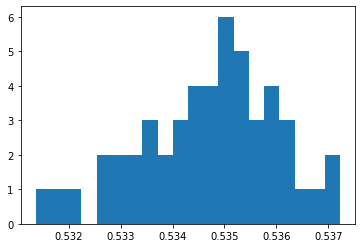

In [29]:
hist(scores_tr, 20);

In [30]:
mean(scores_tr)

0.5347080232138759

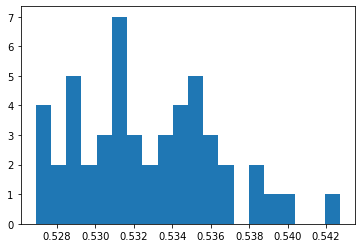

In [31]:
hist(scores_ts, 20);

In [32]:
mean(scores_ts)

0.5327294187075833

In [33]:
# Here the model is saved
#pkl.dump(clf, open('test.pkl','wb'))

In [34]:
input_source.shape, to_predict.shape, test_input_source.shape, test_to_predict.shape

((320, 41078), (41078,), (320, 10270), (10270,))

In [35]:
traded_amt = 100
commission = 0
slippage = 0
initial_balance = 100000000

In [36]:
def plot_backtest(datapair, clfs):
    input_source, to_predict = datapair
    bars_per_episode = len(to_predict) - 1000
    env = TradingEnv(input_source.T, to_predict,
                     winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt,
                     commission=commission, slippage=slippage,
                     initial_balance=initial_balance,
                     reward_type='cur_balance',
                     min_ratio_trades = 20,
                     max_position_time = 0,
                     )
    observation = env.reset()
    done = False
    navs = []
    acts = []
    try:
        for i in tqdm(range(env.bars_per_episode)):
            aa = [clf.predict([observation]) for clf in clfs]
            aa = [int(a) for a in aa]
            # get the average
            a = round(mean(aa))
            if not binary:
                if   a == 0: # up
                    action = 0 # buy
                elif a == 1: # mid 
                    action = 3 # do nothing
                elif a == 2: # down
                    action = 1 # sell
            else:
                if   a == 0: # up
                    action = 0 # buy
                elif a == 1: # down
                    action = 1 # sell
            acts.append(action)
            observation, reward, done, info = env.step(action)
            if done:
                break
    except KeyboardInterrupt:
        pass
    navs = env.returns
    kl = []
    t = 0
    for n in navs:
        t = t + n
        kl.append(t)
    plt.plot(kl)
    plt.show()

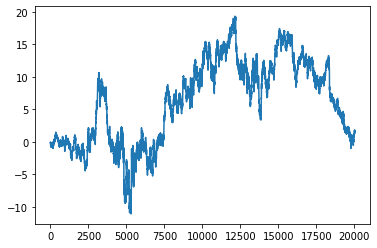

In [37]:
plot_backtest((input_source, to_predict), clfs)

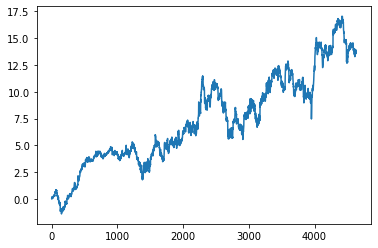

In [38]:
plot_backtest((test_input_source, test_to_predict), clfs)